<a href="https://colab.research.google.com/github/PIYALI-bhunia/MultimodelDataPreprocessing/blob/main/Feature_Integration_Bert_MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multimodal Integration

In [1]:
!pip install -q tensorflow_text
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, Adamax

     |████████████████████████████████| 4.9 MB 34.9 MB/s 
     |████████████████████████████████| 462 kB 57.4 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the dataset and merge Text and Image

In [3]:
img_data_root = pathlib.Path('/content/drive/MyDrive/Tobacco3482-jpg/')
print(img_data_root)
for item in img_data_root.iterdir():
  print(item)

print()

text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')
print(text_data_root)
for item in text_data_root.iterdir():
  print(item)


/content/drive/MyDrive/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Letter
/content/drive/MyDrive/Tobacco3482-jpg/Tobacco3482-jpg
/content/drive/MyDrive/Tobacco3482-jpg/Scientific
/content/drive/MyDrive/Tobacco3482-jpg/Memo
/content/drive/MyDrive/Tobacco3482-jpg/Note
/content/drive/MyDrive/Tobacco3482-jpg/Report
/content/drive/MyDrive/Tobacco3482-jpg/News
/content/drive/MyDrive/Tobacco3482-jpg/Email
/content/drive/MyDrive/Tobacco3482-jpg/Form
/content/drive/MyDrive/Tobacco3482-jpg/Resume
/content/drive/MyDrive/Tobacco3482-jpg/ADVE

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Scientific
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE


In [4]:
def get_corresponding_txtpath(img_path):
    return img_path.replace("Tobacco3482-jpg", "tobaco_OCR")[:-3] + "txt"
    

def get_file_paths_and_labels(img_data_root, text_data_root):
     img_paths = [str(path) for path in img_data_root.glob('*/*.jpg')]
     text_paths = [get_corresponding_txtpath(this_path) for this_path in img_paths]
     img_labels = [p.split("/")[-2] for p in img_paths]
     text_labels = [p.split("/")[-2] for p in text_paths]
     return img_paths, img_labels, text_paths, text_labels

img_paths, img_labels, text_paths, text_labels = get_file_paths_and_labels(img_data_root, text_data_root)
print(len(img_paths))
print(len(img_labels))
print(len(text_paths))
print(len(text_labels))


3482
3482
3482
3482


In [5]:
def get_text_from_path(path):
    with open(path) as f:
        lines = f.readlines()
        lines  = ' '.join(lines)
        f.close()
    return lines

out_text = get_text_from_path('/content/drive/MyDrive/tobaco_OCR/ADVE/0000435350.txt') 
# out_text = preprocess_text(out_text)
print(out_text)


 TE che fitm
 m66400 7127
 KOOLS are the only cigarettes that taste
 good when you have &® cold. They taste even
 better when you don't.
 Job No, K-2978
 ‘Mevapapars—300 iner—Mareh & April, 1956
 (5 9-4 in 4 108 ines) Pinel Proof (7) March 15, 1956



In [6]:
# text_containts = [get_text_from_path(this_path) for this_path in text_paths]
text_contains = []

c= 0 
for i, this_path in enumerate(text_paths):
    text_contains.append(get_text_from_path(this_path))
    print(c)
    c +=1 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
df = pd.DataFrame(list(zip(text_paths, text_contains, img_paths, img_labels)),
               columns =['text_paths','texts', 'img_paths', 'data_label'])

# Merged Dataframe
df.head()

,text_paths,texts,img_paths,data_label
0,/content/drive/MyDrive/tobaco_OCR/Letter/00000...,Letter to the Editor of Personnel Administrato...,/content/drive/MyDrive/Tobacco3482-jpg/Letter/...,Letter
1,/content/drive/MyDrive/tobaco_OCR/Letter/10005...,\n \n AMarriotts\n Campeibacks ne\n Resort and...,/content/drive/MyDrive/Tobacco3482-jpg/Letter/...,Letter
2,/content/drive/MyDrive/tobaco_OCR/Letter/10164...,HKo17 54006\n I THE FRANKLIN INSTITUTE\n RESEA...,/content/drive/MyDrive/Tobacco3482-jpg/Letter/...,Letter
3,/content/drive/MyDrive/tobaco_OCR/Letter/10162...,"\n \n \n aunt aoe ae\n CE ua"" ""gl bib RKB17150...",/content/drive/MyDrive/Tobacco3482-jpg/Letter/...,Letter
4,/content/drive/MyDrive/tobaco_OCR/Letter/10021...,"YF UL Tbs\n Novertber 10, 1982\n < Re: Grant N...",/content/drive/MyDrive/Tobacco3482-jpg/Letter/...,Letter


In [8]:
# 20% for test
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["data_label"].values, random_state=42)
# 10% for validation
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df["data_label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 2506
Total validation examples: 279
Total test examples: 697


In [ ]:
# length=len(test_df)
# batch_size=32
# def scalar(x):
#     return x/127.5-1 # rescales pixels to range -1 to +1

# trgen=tf.keras.preprocessing.image.ImageDataGenerator(
#     preprocessing_function=scalar, 
#     shear_range=0.15,
# )

# train_gen=trgen.flow_from_dataframe(train_df, x_col='img_paths', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=True)

# tvgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)

# valid_gen=tvgen.flow_from_dataframe(val_df, x_col='img_paths', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=False)

# # determine test generator batch size and steps to go through the test set exactly once for predictions
# test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
# test_steps=int(length/test_batch_size)
# test_gen=tvgen.flow_from_dataframe(test_df, x_col='img_paths', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=test_batch_size, shuffle=False)

# test_labels=test_gen.labels

In [9]:
def dataframe_to_dataset(dataframe):
    columns = ["text_paths","texts", "img_paths", "data_label"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("data_label")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds



In [10]:
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, (224, 224))
    
    return image


def preprocess_text(text):
    preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    bert_preprocess_model = hub.KerasLayer(preprocess_url)
    text = tf.convert_to_tensor([text])
    output = bert_preprocess_model(text)
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image = preprocess_image(sample["img_paths"])
    text = preprocess_text(sample["texts"])
    return {"image_inputs": image,  "text_inputs": text}

In [11]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

In [12]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

In [13]:
def create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, trainable=False):

    # preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
    # bert_preprocess_model = hub.KerasLayer(preprocess_url)
    bert_model = hub.KerasLayer(encoder_url)
    # text_projection_dims = 128

    # Set the trainability of the base encoder.
    bert_model.trainable = trainable

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    # preprocessed_input = bert_preprocess_model(inputs)
    embeddings = bert_model(inputs)["pooled_output"]

    outputs = project_embeddings(embeddings, num_projection_layers, text_projection_dims, dropout_rate)

    return keras.Model(inputs, outputs, name="text_encoder")

In [14]:
def create_vision_encoder(num_projection_layers, img_projection_dims, dropout_rate, trainable=False):
  img_shape=(224,224,3)
  class_count = len(set(df['data_label']))
  neurons=512
  dropout=.2
  seed_value = 42


  base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet') 
#   if freeze:
#       base_model.trainable=False

#   x=base_model.output
#   x=tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99 , epsilon=0.001 )(x)
#   x =tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)
#   x=tf.keras.layers.Dropout(rate=dropout, seed=seed_value)(x)
#   x=tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform())(x)
#   x = keras.layers.LayerNormalization()(x)
#   model=Model(inputs=base_model.input, outputs= x)

 
  for i,layer in enumerate(base_model.layers):
    print(i,layer.name)     
  
  # Set the trainability of the base encoder.
  for layer in base_model.layers:
      layer.trainable = trainable

  # Receive the images as inputs.
  image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
#   preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image_inputs)

  embeddings = base_model(image_inputs)

  outputs = project_embeddings(
        embeddings, num_projection_layers, img_projection_dims, dropout_rate
    )

  # Preprocess the input image.
#   trgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= scalar, shear_range=0.1)
#   preprocess_image=trgen.flow_from_dataframe(train_df, x_col='image_path', y_col='data_label', target_size=(224,224), class_mode='categorical',batch_size=batch_size, shuffle=True)
   
#   model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

  # Generate the embeddings for the images using the resnet_v2 model
  # concatenate them.


   # Create the vision encoder model.
  return keras.Model(image_inputs, outputs, name="vision_encoder")

In [15]:
def create_multimodal_model(
    num_projection_layers=1,
    img_projection_dims=128,
    text_projection_dims=128,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images and text as inputs.
    image_inputs = keras.Input(shape=(224, 224, 3), name="image_inputs")
    # text_inputs = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_inputs")

    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(num_projection_layers, img_projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, text_projection_dims, dropout_rate, text_trainable)
    # print(keras.utils.plot_model(text_encoder, show_shapes=True))

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image_inputs)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(10, activation="softmax")(concatenated)
    return keras.Model([image_inputs, text_inputs], outputs)


multimodal_model = create_multimodal_model()
# keras.utils.plot_model(multimodal_model, show_shapes=True)

9420800/9406464 [==============================] - 0s 0us/step
0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 

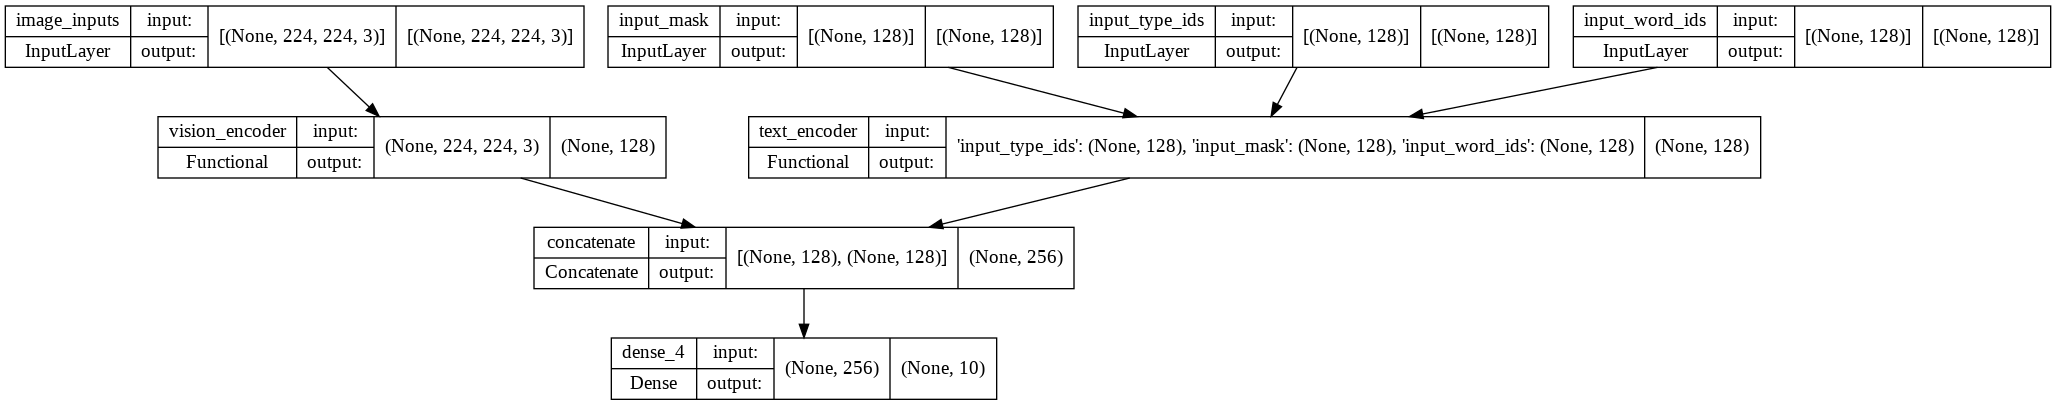

In [16]:
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [17]:
lr = 0.001
multimodal_model.compile(
    Adamax(learning_rate=lr), loss="sparse_categorical_crossentropy", metrics="accuracy"
)

In [18]:
history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=10)

Epoch 1/10


UnimplementedError: ignored

# Text Data    # For Testing only


In [19]:
import numpy as np
import pandas as pd
import os
import pathlib
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

In [20]:
text_data_root = pathlib.Path('/content/drive/MyDrive/tobaco_OCR/')

print(text_data_root)
for item in text_data_root.iterdir():
  print(item)

/content/drive/MyDrive/tobaco_OCR
/content/drive/MyDrive/tobaco_OCR/Scientific
/content/drive/MyDrive/tobaco_OCR/Resume
/content/drive/MyDrive/tobaco_OCR/Report
/content/drive/MyDrive/tobaco_OCR/Note
/content/drive/MyDrive/tobaco_OCR/Memo
/content/drive/MyDrive/tobaco_OCR/News
/content/drive/MyDrive/tobaco_OCR/Letter
/content/drive/MyDrive/tobaco_OCR/Form
/content/drive/MyDrive/tobaco_OCR/Email
/content/drive/MyDrive/tobaco_OCR/ADVE


In [21]:
def get_file_paths_and_labels(data_root):
     text_paths = [str(path) for path in data_root.glob('*/*.txt')]
     labels = [p.split("/")[-2] for p in text_paths]
     return text_paths, labels

text_paths, labels = get_file_paths_and_labels(text_data_root)
print(len(text_paths))
print(len(labels))

3482
3482


In [22]:
text_df = pd.DataFrame(list(zip(text_paths, labels)),
               columns =['text_path', 'data_label'])
text_df.head()

,text_path,data_label
0,/content/drive/MyDrive/tobaco_OCR/Scientific/2...,Scientific
1,/content/drive/MyDrive/tobaco_OCR/Scientific/2...,Scientific
2,/content/drive/MyDrive/tobaco_OCR/Scientific/P...,Scientific
3,/content/drive/MyDrive/tobaco_OCR/Scientific/2...,Scientific
4,/content/drive/MyDrive/tobaco_OCR/Scientific/1...,Scientific


In [23]:
def get_text_from_path(path):
    with open(path) as f:
        lines = f.readlines()
        lines  = ' '.join(lines)
        f.close()
    return lines

out_text = get_text_from_path('/content/drive/MyDrive/tobaco_OCR/ADVE/0000435350.txt') 
print(out_text)


 TE che fitm
 m66400 7127
 KOOLS are the only cigarettes that taste
 good when you have &® cold. They taste even
 better when you don't.
 Job No, K-2978
 ‘Mevapapars—300 iner—Mareh & April, 1956
 (5 9-4 in 4 108 ines) Pinel Proof (7) March 15, 1956



In [24]:
# preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
# encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2"
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_model = hub.KerasLayer(encoder_url)

In [25]:
texts = []
c = 0
for this_path in text_paths:
    texts.append(get_text_from_path(this_path))
    print(c)
    c += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
text_preprocessed = bert_preprocess_model(texts)
bert_results = bert_model(text_preprocessed)

In [27]:
out = bert_results['pooled_output']

In [28]:
vec_df = pd.DataFrame(out)

## this vec_df contain the senetence embedding for the texts (No labels added yet)

# Image data


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import pathlib
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
a = [[1,2],[3,4]]
b = []